---
badges: true
categories: [fastai, huggingface, datasets]
date: '2023-04-30'
title: How to use HuggingFace datasets with fastai?
toc: false
---

In this tutorial, we will show you how to use a HuggingFace dataset with fastai to train a model for image classification. We will use the [Beans dataset](https://huggingface.co/datasets/beans), which consists of images of beans with three different types of diseases.

## Step 1: Install the required libraries
Before starting, we need to install the required libraries. Run the following commands to install fastai and HuggingFace's datasets:

In [ ]:
!pip install -Uqq fastai
!pip install -Uqq datasets

Login to HuggingFace Hub to download the dataset.

In [ ]:
!huggingface-cli login

## Step 2: Import the required modules



In [4]:
#| output: False
import torch
from fastai.data.all import *
from fastai.vision.all import *
from datasets import load_dataset

In [3]:
#| echo: False
if not torch.cuda.is_available():
    default_device(False)

## Step 3: Load the dataset


Let's load [Beans dataset](https://huggingface.co/datasets/beans), which is a dataset of images of beans taken in the field using smartphone cameras. It consists of 3 classes: 2 disease classes and the healthy class.

In [5]:
#| output: False
raw_ds = load_dataset("beans")

Found cached dataset beans (/Users/bdsaglam/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791)
100%|██████████| 3/3 [00:00<00:00, 418.94it/s]


In [6]:
raw_ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

The dataset is splitted into train, validation, and test sets.

Let's see label names.

In [7]:
class_names = raw_ds['train'].features['labels'].names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

## Step 4: Preprocess the dataset

Often, we need preprocessing raw data before training a model with it. HuggingFace `datasets` library provides two methods for preprocessing:

1. `map`: This method is used to apply a function to each example in the dataset, possibly in a batched manner. The function can be applied to one or more columns of the dataset, and the result can be stored in a new column or overwrite the existing one. The map function also allows you to remove some columns from the dataset, if needed. This method is useful for preprocessing the dataset, such as resizing images, tokenizing text, or encoding categorical features. It caches outputs so that they're not computed again.

2. `set_transforms`: This method is used to set a transform function that is applied on-the-fly when accessing examples from the dataset. This means that the dataset is not modified in-place, and the transform function is applied only when the examples are accessed. This method is useful for applying data augmentation techniques or normalization that should be applied dynamically during training without modifying the dataset beforehand.



Let's resize each image to 224x244.

In [8]:
def preprocess(records):
    records["image"] = [image.convert("RGB").resize((224, 224)) for image in records["image"]]
    return records

Before batching samples, we need to remove unnecessary columns in the dataset such as `image_file_path`.

In [9]:
ds = raw_ds.map(preprocess, remove_columns=["image_file_path"], batched=True)

Loading cached processed dataset at /Users/bdsaglam/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791/cache-d335def00fc26298.arrow
Loading cached processed dataset at /Users/bdsaglam/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791/cache-9b27f1e864a73628.arrow
Loading cached processed dataset at /Users/bdsaglam/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791/cache-417ffd63aef737e6.arrow


In [10]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'labels': 0}

We won't use `set_transform` as fastai's DataBlock can apply item-level and batch-level transforms, e.g. data augmentations, normalization. When we use a pretrained model, it already applies necessary transforms such as normalization.

## Step 5: Create the DataBlock

Now, we can create dataloaders for the dataset using DataBlock from fastai. As the dataset is already splitted into train, validation, and test sets, we don't need to split it further. Hence, we will use `nosplit` function.

In [11]:
def nosplit(items): 
    return list(range(len(items))), []

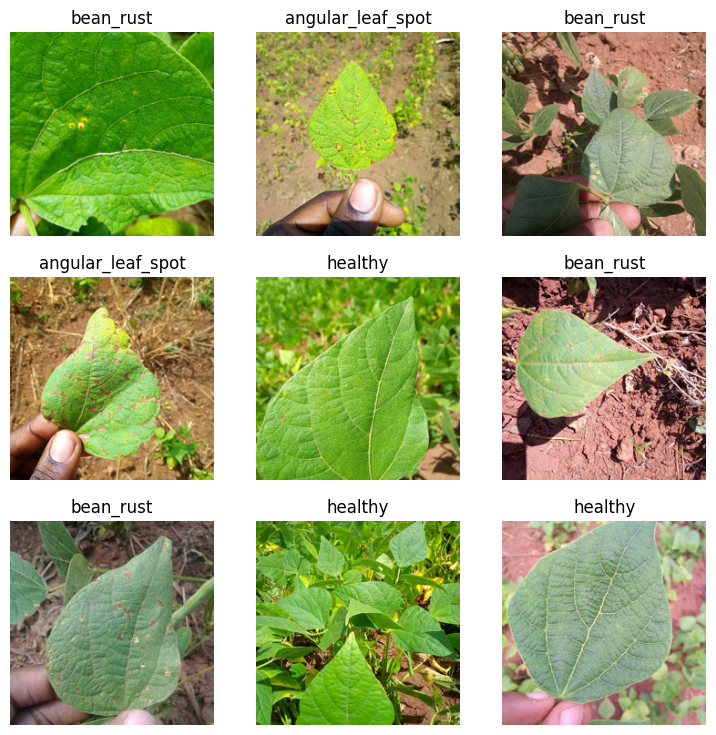

In [12]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=lambda record: record['image'],
    get_y=lambda record: class_names[record['labels']],
    splitter = nosplit,
)

train_dl = dblock.dataloaders(ds['train']).train
valid_dl = dblock.dataloaders(ds['validation']).train
dls = DataLoaders(train_dl, valid_dl)

dls.show_batch()

In [13]:
len(dls.train.dataset),len(dls.valid.dataset)

(1034, 133)

## Step 6: Training

Let's fine-tune a pretrained ResNet model on our dataset using `Learner.fine_tune` method.


In [14]:
#| output: False
learn = vision_learner(
    dls, 
    resnet34, 
    loss_func=CrossEntropyLossFlat(),
    metrics=accuracy, 
)

/Users/bdsaglam/bloq/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bdsaglam/bloq/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0004786300996784121)

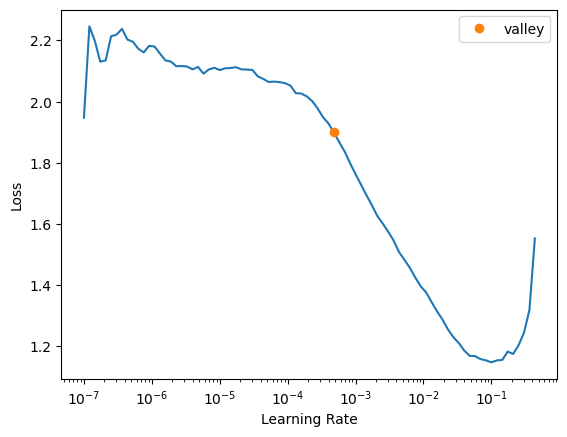

In [15]:
# Find a good learning rate
learn.lr_find()

In [16]:
# Fine-tune the model
learn.fine_tune(1, 1e-3, freeze_epochs=2)

## Step 7: Evaluation

Only after 3 epochs, fine-tuned model achieves 90.6% accuracy on validation set, not too bad!

In [17]:
loss, accuracy = learn.validate(dl=dls.valid)
print(f"Loss {loss:.6f}\nAccuracy: {accuracy:.2%}")

Loss 0.306838
Accuracy: 90.62%


Let's check predictions visually.

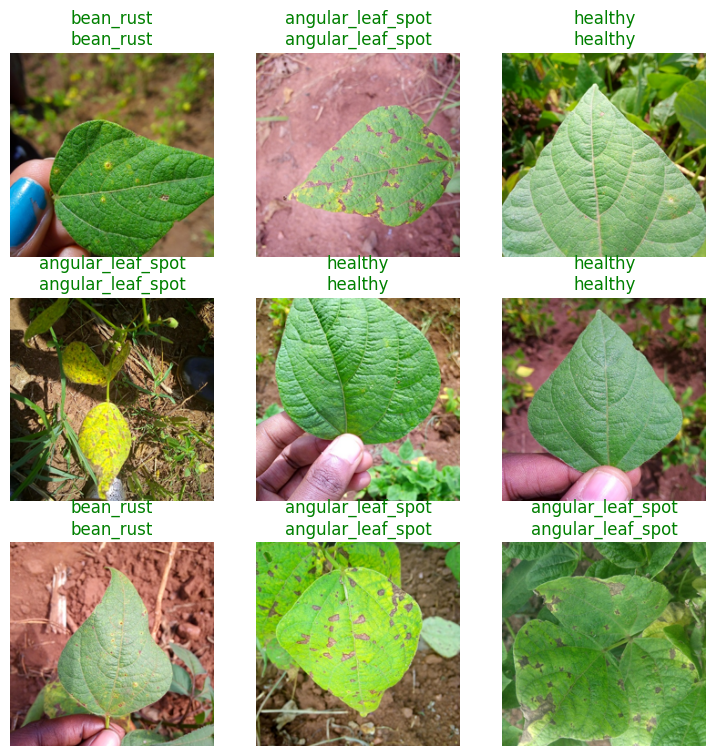

In [18]:
learn.show_results(dl=valid_dl)

Let's predict and evaluate on test set.

In [19]:
tst_dl = dls.test_dl(ds['test'], with_labels=True)
probs, targets, preds = learn.get_preds(dl=tst_dl, with_decoded=True)

In [20]:
loss, accuracy = learn.validate(dl=tst_dl)
print(f"Loss {loss:.6f}\nAccuracy: {accuracy:.2%}")

Loss 0.288472
Accuracy: 89.06%
